<img src="http://hilpisch.com/tpq_logo.png" width="36%" align="right" style="vertical-align: top;">

# Natural Language Processing

**Basic Techniques and Algorithms**

Dr Yves J Hilpisch | Michael Schwed

The Python Quants GmbH

## Text Retrieval

In [1]:
import sys
sys.path.append('../')

In [2]:
import requests
import nlp_functions as nlp

In [5]:
sources = [
    'https://developer.dowjones.com/site/global/develop/introduction/index.gsp',
]

In [6]:
html = [requests.get(url).text for url in sources]

## Text Parsing

In [7]:
from bs4 import BeautifulSoup

In [8]:
raw = [BeautifulSoup(nlp.cleaner.clean_html(h), 'html5lib').get_text()
       for h in html]

## Text Cleaning

In [9]:
data = [nlp.clean_up_text(t) for t in raw]

In [10]:
data[0][:1000]

'div dow jones dna develop support faq contact us general support contact sales login develop introduction subscribe to email updates about dna develop support introduction getting started with dna authentication working with the dna apis data introduction organizations api people api calendar live api news introduction content api djid taxonomy api analytics amp services introduction snapshots streams batch screening faq contact us general support contact sales logout develop introduction subscribe to email updates about dna introduction getting started with dna authentication working with the dna apis data introduction organizations api people api calendar live api news introduction content api djid taxonomy api analytics amp services introduction snapshots streams batch screening data news analytics text mining derive data to spot trends opportunities and disruptors data augmentation enhance the data quality and complexity of existing databases data integration bring new content int

## Basic Text Analysis

In [11]:
import nltk

In [13]:
# needs to be executed once
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('vader_lexicon')

### Basic Tokenization

In [14]:
tokens = nltk.word_tokenize(' '.join(data))

In [15]:
tokens[:10]

['div',
 'dow',
 'jones',
 'dna',
 'develop',
 'support',
 'faq',
 'contact',
 'us',
 'general']

In [16]:
text = nltk.Text(tokens)

In [18]:
text.concordance('dna')

Displaying 8 of 8 matches:
 dna develop support faq contact us genera
tion subscribe to email updates about dna develop support introduction getting 
ort introduction getting started with dna authentication working with the dna a
h dna authentication working with the dna apis data introduction organizations 
tion subscribe to email updates about dna introduction getting started with dna
dna introduction getting started with dna authentication working with the dna a
h dna authentication working with the dna apis data introduction organizations 
ine learning initiatives develop with dna dow jones amp company inc all rights 


### Basic Vocabulary 

In [19]:
words = sorted(set([w.lower() for w in tokens]))
len(words)

147

In [20]:
words[:7]

['a', 'about', 'access', 'actionable', 'all', 'amp', 'analytics']

## Improved Tokenization

In [21]:
%time tokens = nlp.tokenize(' '.join(data))

CPU times: user 1.64 s, sys: 81.4 ms, total: 1.72 s
Wall time: 1.73 s


In [22]:
tokens[:10]

['jones',
 'develop',
 'support',
 'contact',
 'general',
 'support',
 'contact',
 'sales',
 'login',
 'develop']

### Improved Vocabulary 

In [23]:
words = sorted(set([w.lower() for w in tokens]))
len(words)

93

In [24]:
words[:7]

['access',
 'actionable',
 'analytics',
 'application',
 'apply',
 'archives',
 'augmentation']

### Word Clouds

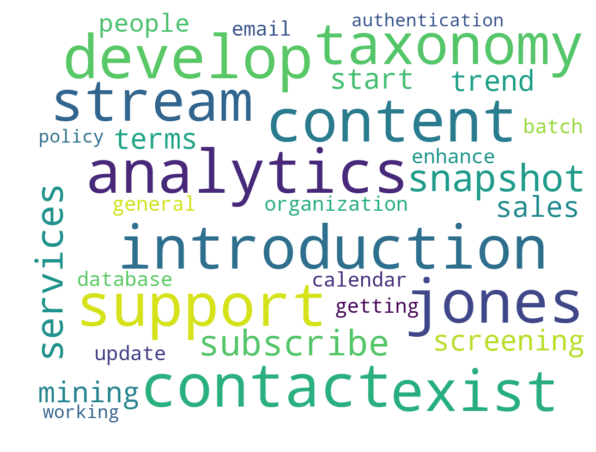

In [29]:
nlp.generate_word_cloud(' '.join(data), 35)

## Topic Modeling

In [30]:
import gensim
from gensim import corpora

In [31]:
token_list = [nlp.tokenize(t) for t in data]

In [32]:
dictionary = corpora.Dictionary(token_list)

In [33]:
corpus = [dictionary.doc2bow(tokens) for tokens in token_list]

In [35]:
NUM_TOPICS = 3

In [36]:
%%time
lda = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS,
                                      id2word=dictionary, passes=15)

CPU times: user 20.9 ms, sys: 1.5 ms, total: 22.4 ms
Wall time: 20.8 ms


In [37]:
topics = lda.print_topics(num_words=5)

In [38]:
for topic in topics:
    print(topic)

(0, '0.072*"introduction" + 0.039*"develop" + 0.029*"content" + 0.023*"contact" + 0.023*"support"')
(1, '0.011*"introduction" + 0.011*"develop" + 0.011*"content" + 0.011*"support" + 0.011*"jones"')
(2, '0.011*"introduction" + 0.011*"develop" + 0.011*"content" + 0.011*"jones" + 0.011*"contact"')


## Clustering

### KMeans

In [39]:
import collections
from sklearn.cluster import KMeans

In [49]:
token_list = [' '.join(nlp.tokenize(l)) for l in data]

In [53]:
vec = TfidfVectorizer(min_df=1,
                      analyzer='word',
                      ngram_range=(1, 2),
                      stop_words='english'
                     )

In [54]:
vec

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [55]:
sm = vec.fit_transform(token_list)

In [56]:
n_clusters = 3

In [57]:
%%time
km = KMeans(n_clusters=n_clusters)
km.fit(sm)

ValueError: n_samples=1 should be >= n_clusters=3

In [52]:
clustering = collections.defaultdict(list)
for idx, label in enumerate(km.labels_):
    clustering[label].append(idx)

In [53]:
# pprint(clustering)

In [54]:
n_kw = 8

In [55]:
sorted_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names()
kw_list = []
for i in range(n_clusters):
    keywords = []
    for j in sorted_centroids[i, :n_kw]:
        keywords.append(terms[j])
    kw_list.append(keywords)

In [56]:
# kw_list

In [57]:
kw_df = pd.DataFrame(index=['topic_{}'.format(i) for i in range(n_clusters)], 
                           columns=['keyword_{}'.format(i) for i in range(n_kw)],
                           data=kw_list)

In [58]:
kw_df

,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7
topic_0,apple,macbook,feature,fast,performance,thunderbolt,desktop,processor
topic_1,apple,mobile,close,store,music,business,powerful,design
topic_2,company,apple,quarter,billion,services,product,result,include


### Matrix Factorization (NMF)

In [59]:
from sklearn.decomposition import NMF

In [60]:
vec = TfidfVectorizer(min_df=2, analyzer='word',
                      ngram_range=(1, 2),
                      stop_words='english')

In [61]:
vz = vec.fit_transform(data)

In [62]:
%%time
nmf = NMF(n_components=len(data), random_state=1,
          alpha=.1, l1_ratio=.5,
          init='nndsvd').fit(vz)

CPU times: user 51.8 ms, sys: 5.84 ms, total: 57.7 ms
Wall time: 20.1 ms


In [63]:
feature_names = vec.get_feature_names()
n_topics = 5
for i, topic in enumerate(nmf.components_[:n_topics]):
    print('topic %d:'% (i))
    print(' | '.join([feature_names[i] for i in topic.argsort()[:-n_topics-1:-1]]))

topic 0:
apple | menu | close | open menu | open
topic 1:
macbook | air | macbook air | new macbook | new
topic 2:
pro | ipad | new | inch | keyboard
topic 3:
mac | faster | new | gb | performance
topic 4:
quarter | billion | results | services | products


## Sentiment Analysis

In [64]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [65]:
sid = SentimentIntensityAnalyzer()

In [66]:
sid.polarity_scores(' '.join(data))

{'neg': 0.01, 'neu': 0.883, 'pos': 0.107, 'compound': 1.0}

In [67]:
scores = [sid.polarity_scores(l) for l in data]

In [68]:
score_df = pd.DataFrame(scores)

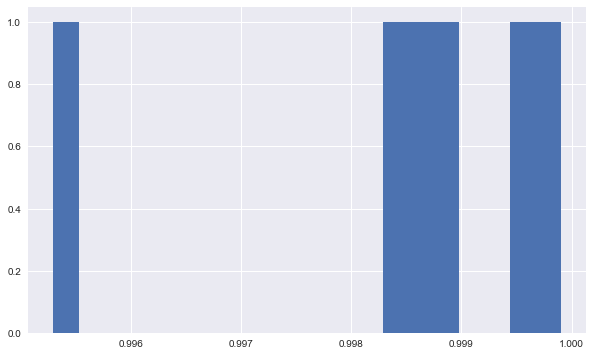

In [69]:
score_df['compound'].hist(figsize=(10, 6), bins=20);

<img src="http://hilpisch.com/tpq_logo.png" width="36%" align="right" style="vertical-align: top;">